# Mathjax custom 

$ \newcommand{\opexpect}[3]{\langle #1 \vert #2 \vert #3 \rangle} $
$ \newcommand{\rarrow}{\rightarrow} $
$ \newcommand{\bra}{\langle} $
$ \newcommand{\ket}{\rangle} $

$ \newcommand{\up}{\uparrow} $
$ \newcommand{\down}{\downarrow} $

$ \newcommand{\mb}[1]{\mathbf{#1}} $
$ \newcommand{\mc}[1]{\mathcal{#1}} $
$ \newcommand{\mbb}[1]{\mathbb{#1}} $
$ \newcommand{\mf}[1]{\mathfrak{#1}} $

$ \newcommand{\vect}[1]{\boldsymbol{\mathrm{#1}}} $
$ \newcommand{\expect}[1]{\langle #1\rangle} $

$ \newcommand{\innerp}[2]{\langle #1 \vert #2 \rangle} $
$ \newcommand{\fullbra}[1]{\langle #1 \vert} $
$ \newcommand{\fullket}[1]{\vert #1 \rangle} $
$ \newcommand{\supersc}[1]{^{\text{#1}}} $
$ \newcommand{\subsc}[1]{_{\text{#1}}} $
$ \newcommand{\sltwoc}{SL(2,\mathbb{C})} $
$ \newcommand{\sltwoz}{SL(2,\mathbb{Z})} $

$ \newcommand{\utilde}[1]{\underset{\sim}{#1}} $

# Neural Networks With NetworkX

Reference: [Using neural nets to recognize handwritten digits](http://neuralnetworksanddeeplearning.com/chap1.html), Nielsen, Deep Learning

In [2]:
import matplotlib
matplotlib.use('qt4agg')
%matplotlib inline

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx import Graph, DiGraph

In [4]:
import numpy as np

In [5]:
# import uud1 function from uuid module, to assign a unique id to each graph
from uuid import uuid1

## `switch` class defintion

In [6]:
# This class provides the functionality we want. You only need to look at
# this if you want to know how this works. It only needs to be defined
# once, no need to muck around with its internals.

# v = 'ten'
# for case in switch(v):
#     if case('one'):
#         print 1
#         break
#     if case('two'):
#         print 2
#         break
#     if case(): # default, could also just omit condition or 'if True'
#         print "something else!"
#         # No need to break here, it'll stop anyway

class switch(object):
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args: # changed for v1.5, see below
            self.fall = True
            return True
        else:
            return False

## Composing Graphs

In order to make composite perceptrons we need to combine two or perceptrons to form a larger graph. For this we can use the following `networkx` functions:
* `compose(G,H)`: Returns the simple union of the edge and node sets of the two graphs. Any nodes or edges which have the same labels in G and H, are merged in the composite graph.
* `union(G,H)`: Graphs must be disjoint, i.e. labels of nodes and edges must be different, otherwise raises an exception
* `disjoint_union(G,H)`: Graphs need not be disjoint. Nodes and edges of both graphs are relabeled in order to ensure distinct labels for each element.

For our purposes `disjoint_union` is suitable, but then we have to save node and edge labels as graph attributes.


### Assigning Unique Labels to Perceptrons

There are several ways to assign unique labels to objects of any type. One way is to the `uuid` module to generate a **universal identifier** in the `__init__` method and save it in a class variable. However, uids are very long strings and do not reveal any information about the object as such:
```python
import uuid
uuid.uuid1()
    
UUID('5f32a83e-cc0d-11e5-8c8a-60f81dd1cf3a')
```    
Another solution would be to use the name used to instantiate the object as the object's unique id. However, that name is not bound to the object until *after* the `__init__` method is executed. A possible simple alternative ([Reference: StackEx](https://stackoverflow.com/a/1690433/506434)) is to simply pass the name to `__init__` when declaring the object, as in:
```python
def __init__(self, name):
    self.name = name
```
This method seems most straightforward and also allows us to assign as simple or as complicated names we like to objects. We will use this method from now on.

In [5]:
import uuid
uuid.uuid1()

UUID('3135eed2-d3c4-11e5-9783-60f81dd1cf3a')

In previous attempts, the `Perceptron` class was becoming too complex. Let us attempt again to make a simple class which does exactly what a perceptron is supposed to do, and nothing more.

## `simplePerceptron` class defintion

In [29]:
class simplePerceptron(Graph):
    
    weights = []
    bias = 0
    _uuid = None
    name = None
        
    node_color_map = {}
    edge_color_map = {}

    node_colors = [] # list whose elements are colors for each node
    node_color_map = {'InternalNode': 'red',
                       'OutputNode': 'green',
                       'InputNode': 'blue'}
    
    node_color_dict = {}
    
    central_node_pos = (0,0) # location of central node, relative to which all the other nodes and edges are drawn
    
    central_node_dir = 0 # determines orientation of perceptron in two-dimensional plane, 0 corresponding to
    # the edge from i0 to y0 pointing in +ve x-axis and 180 for -ve y-axis.
    
    node_pos_dict = {}
    node_label_dict = {}
    
    edge_color_dict = {} # dictionary whose keys are edges and values are colors for each edge
    edge_colors = []
    
    free_input_nodes = 0   # the number of free input and output nodes, respectively
    free_output_nodes = 0 

    
    def __init__(self, name=None, weights = None, bias = None):
            
        if weights!=None:
            if not isinstance(weights,list):
                raise ValueError("weights must be a list")
            if len(weights)!=numIn:
                raise ValueError("Number of weights must equal number of input nodes")
            if not all(isinstance(x,float) for x in weights):
                raise ValueError("weights must contain only real numbers")
            
        if bias!=None:
            if not isinstance(bias,float):
                raise ValueError("bias must be a real number")
    
        Graph.__init__(self)
        
        self._uuid = uuid1()
        if name==None:
            self.name = str(self._uuid)
        else:
            self.name = str(name)

        self.weights = weights
        self.bias = bias
        
        self.addCentralNode()

        self.addInputNode(0)
        self.addInputNode(1)

        self.addOutputNode(0)
        
        self.free_input_nodes = 2
        self.free_output_nodes = 1
        
        self.assignDefaultPositions()
        self.assignNodeColors()
            
    def addCentralNode(self):
        # DiGraph.add_node(self,0,Type="Central")
        node_name = self._name(0,"InternalNode")
        Graph.add_node(self,node_name,Type="InternalNode")
        self.node[node_name]['pos'] = (0,0)
        self.node[node_name]['color'] = 'green'
        self.node_label_dict[node_name] = node_name
    
    def addInputNode(self,i):
        node_name = self._name(i,"InputNode",0)
        Graph.add_node(self,node_name,Type="InputNode")
        Graph.add_edge(self,node_name,self._name(0,"InternalNode"),Type="InputEdge")
        self.node[node_name]['connected'] = False
        self.node[node_name]['color'] = 'blue'
        self.node_label_dict[node_name] = node_name
            
    def addOutputNode(self,i):
        node_name = self._name(i,"OutputNode",0)
        Graph.add_node(self,node_name,Type="OutputNode")
        Graph.add_edge(self,self._name(0,"InternalNode"),node_name,Type="OutputEdge")
        self.node[node_name]['connected'] = False
        self.node[node_name]['color'] = 'red'
        self.node_label_dict[node_name] = node_name

    def assignNodeColors(self):
        '''Assigns colors to nodes, depending on whether they are input, output or internal nodes'''
        self.node_colors = []
        for node in self.nodes():
            self.updateNodeColor(node)
            self.node_colors.append(self.node_color_dict[node])
#             self.node_colors.append(self.node_color_dict[self.node[n]['Type']])
#             print(self.node_color_dict[self.node[n]['Type']])
        
    def translateXY(self,x,y):
        '''Translate all node co-ordinates by an amount x,y along the x and y directions respectively'''
    
        self.central_node_pos[0] += x
        self.central_node_pos[1] += y
    
        for n in self.nodes():
            self.node[n]['pos'][0] += x
            self.node[n]['pos'][1] += y
            
    def rotateTheta(self,theta):
        '''Rotate all node co-ordinates around the central node by an angle theta'''
        
        self.central_node_dir += theta
        
        (x,y) = self.central_node_pos
    
        # translate all nodes back so they are centered around origin.
        self.translateXY(-x,-y)
        
        theta = np.deg2rad(theta)
        
        mat = [[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]]
        
        # perform rotation on each node
        for n in self.nodes():
            old_x = self.node[n]['pos'][0]
            old_y = self.node[n]['pos'][1]
        
            new_x = mat[0][0]*old_x + mat[0][1]*old_y
            new_y = mat[1][0]*old_x + mat[1][1]*old_y
            
            self.node[n]['pos'] = (new_x,new_y)
            
        # translate all nodes back to original positions
        self.translateXY(x,y)

    
    def assignDefaultPositions(self):
        '''Assigns default (relative) co-ordinates to nodes'''
        
        self.node[self._name(0,"InternalNode")]['pos'] = (0,0)
        self.node_pos_dict[self._name(0,"InternalNode")] = (0,0)
        
        self.node[self._name(0,"InputNode")]['pos'] = (-1,1)
        self.node_pos_dict[self._name(0,"InputNode")] = (-1,1)

        self.node[self._name(1,"InputNode")]['pos'] = (-1,-1)
        self.node_pos_dict[self._name(1,"InputNode")] = (-1,-1)
        
        self.node[self._name(0,"OutputNode")]['pos'] = (1,0)
        self.node_pos_dict[self._name(0,"OutputNode")] = (1,0)
    
    def updateNodeColor(self,node):
        self.node_color_dict[node] = self.node_color_map[self.node[node]['Type']]

    def draw(self, draw_nodes=True, draw_edges=True, draw_labels=False):
        if(draw_nodes==False and draw_edges==False and draw_labels==True):
            raise ValueError("If draw_labels is set to True, then one of draw_nodes or draw_edges must also be True")
        plt.axis('off')
#         self.node_colors = []
        
#         for node in self.nodes():
#             self.node_colors.append(self.node_color_dict[node])
            
        if draw_nodes:
            nx.draw_networkx_nodes(self,pos=self.node_pos_dict,node_color=self.node_colors)
        if draw_edges:
            nx.draw_networkx_edges(self,pos=self.node_pos_dict)
        if draw_labels:
            nx.draw_networkx_labels(self,pos=self.node_pos_dict,labels=self.node_label_dict)
#         nx.draw(self,pos=self.node_pos_dict,labels=self.node_label_dict,node_color=self.node_colors)
    
    def _name(self,i,Type,j=0):
        '''Returns a name given a node index (i), node type (Type) and the central node this node is attached to (j)
        
        Example: _name(2,"OutputNode",1)
             >>> graphname.i1.y2
        '''
        
        if Type not in self.node_color_map.keys():
            raise ValueError("Type must be one of: ", self.node_color_map.keys())
                    
        for case in switch(Type):
            if case('InternalNode'):
                return self.name+".i"+str(i)
                break
            if case('InputNode'):
                return self.name+".i"+str(j)+".x"+str(i)
                break
            if case('OutputNode'):
                return self.name+".i"+str(j)+".y"+str(i)
                break
        return  
                
    def __hash__(self):
        '''Defines __hash__ method in order to make class sortable, hashable
        Reference: https://stackoverflow.com/a/7152650/506434
        '''
        return hash(repr(self))

#     def connectPerceptron(self,p2):
#         '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
#         output edge of this node'''
        
#         if not isinstance(p2,namedPerceptron):
#             raise ValueError("First argument must be an object of type Perceptron")
            
#         p3 = namedPerceptron(self.numInputs, p2.numOutputs)
        
#         if p2.free_input_nodes > 0:
#             for i in range(p2.numInputs):
#                 p2node_name = p2._name(i,"InputNode")
#                 if p2.node[p2node_name]['connected'] == False:
#                     p2.node[p2node_name]['connected'] = True
#                     p2.free_input_nodes -= 1
#                     break
#         else:
#             raise RuntimeWarning("No free input edges in second perceptron")
        
#         if self.free_output_nodes > 0:
#             for i in range(self.numOutputs):
#                 p1node_name = self._name(i,"OutputNode")
#                 if self.node[p1node_name]['connected'] == False:
#                     self.node[p1node_name]['connected'] = True
#                     self.free_output_nodes -= 1
#                     break
#         else:
#             raise RuntimeWarning("No free output edges in first perceptron")
            
#         p2.node[p2node_name]['inputFrom'] = {'perceptron': self.name, 'node': p1node_name}
#         self.node[p1node_name]['outputTo'] = {'perceptron': p2.name, 'node': p2node_name}
        
#         return

In [30]:
np1 = simplePerceptron("np1")
np2 = simplePerceptron("np2")

In [31]:
np1.nodes(), np2.nodes()

(['np1.i0', 'np1.i0.y0', 'np1.i0.x0', 'np1.i0.x1'],
 ['np2.i0.y0', 'np2.i0.x0', 'np2.i0.x1', 'np2.i0'])

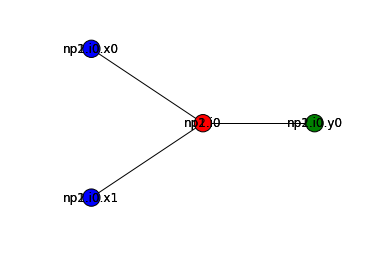

In [32]:
np1.draw(draw_labels=True)

In [26]:
for n in np1.nodes():
    print(n,np1.node[n],np1.neighbors(n))

np1.i0 {'pos': (0, 0), 'Type': 'InternalNode', 'color': 'green'} ['np1.i0.x1', 'np1.i0.y0', 'np1.i0.x0']
np1.i0.y0 {'pos': (1, 0), 'Type': 'OutputNode', 'color': 'red', 'connected': False} ['np1.i0']
np1.i0.x0 {'pos': (-1, 1), 'Type': 'InputNode', 'color': 'blue', 'connected': False} ['np1.i0']
np1.i0.x1 {'pos': (-1, -1), 'Type': 'InputNode', 'color': 'blue', 'connected': False} ['np1.i0']


In [43]:
for n in np2.nodes():
    print(n,np2.node[n], np2.neighbors(n))

np2.i0 {'Type': 'InternalNode', 'pos': (0, 0), 'color': 'green'} []


In [44]:
np1.connectPerceptron(np2)

RuntimeWarning: No free input edges in second perceptron

In [45]:
np2 = namedPerceptron(numIn=3,numOut=3,name="np2")

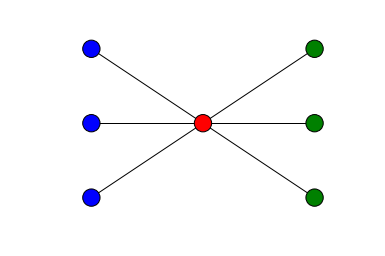

In [48]:
np2.draw()

In [51]:
np2.nodes()

['np2.y1', 'np2.i0', 'np2.x0', 'np2.x2', 'np2.y2', 'np2.x1', 'np2.y0']

In [52]:
for node in np2.nodes():
    print(node,np2.node_color_dict[node])

np2.y1 green
np2.i0 red
np2.x0 blue
np2.x2 blue
np2.y2 green
np2.x1 blue
np2.y0 green


In [67]:
print(np2.node_color_dict.values())

dict_values(['green', 'green', 'green', 'blue', 'blue', 'blue', 'red'])


In [59]:
print(np2.node_colors)

['blue', 'blue', 'green', 'red', 'blue', 'green', 'red', 'blue', 'green', 'red', 'green', 'green', 'blue', 'green', 'red', 'green', 'green', 'red', 'blue', 'green', 'blue', 'blue', 'green']


In [124]:
np1.node_colors

['green', 'blue', 'blue', 'red']

In [11]:
np1 = generalizedPerceptron()
np2 = generalizedPerceptron()

In [53]:
np3 = nx.compose(np1,np2)

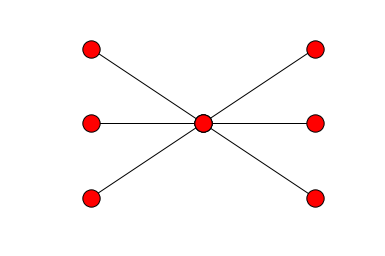

In [54]:
np3.draw()

In [55]:
np3.nodes()

['ec8cc9d0-d3c4-11e5-adc3-60f81dd1cf3a.i0',
 'np2.y2',
 'np2.x1',
 'np2.y0',
 'np1.i0',
 'np2.x0',
 'np2.x2',
 'np2.y1',
 'np2.i0']

In [30]:
type?

In [21]:
getattr?

## `SimplePerceptron` class defintion

In [30]:
class SimplePerceptron(DiGraph):
    
    numInputs = 0
    numOutputs = 1
    weights = []
    bias = 0
    _uuid = None
    
    _maxInputs = 100
    _maxOutputs = 1
    
    def __init__(self, numIn = 2, numOut = 1, weights = None, bias = None):
        
        if not (isinstance(numIn,int) and numIn > 0):
            raise ValueError("numIn must be a non-zero positive integer")
        if numIn > self._maxInputs:
            raise ValueError("numIn cannot be greater than ",self._maxInputs)
            
        if not (isinstance(numOut,int) and numOut > 0):
            raise ValueError("numOut must be a non-zero positive integer")
        if numOut > self._maxOutputs:
            raise ValueError("numOut cannot be greater than ",self._maxOutputs)
            
        if weights!=None:
            if not isinstance(weights,list):
                raise ValueError("weights must be a list")
            if len(weights)!=numIn:
                raise ValueError("Number of weights must equal number of input nodes")
            if not all(isinstance(x,float) for x in weights):
                raise ValueError("weights must contain only real numbers")
            
        if bias!=None:
            if not isinstance(bias,float):
                raise ValueError("bias must be a real number")
    
        DiGraph.__init__(self)
        
        self._uuid = uuid1()
        
        self.numInputs = numIn
        self.numOutputs = numOut
        self.weights = weights
        self.bias = bias

#         DiGraph.add_node(self,0,Type="Central")
        DiGraph.add_node(self,0,Type="Central")
        
        for i in range(numIn):
            DiGraph.add_node(self,i+1,Type="InputNode")
            DiGraph.add_edge(self,i+1,0,Type="InputEdge")
            
        for i in range(numOut):
            DiGraph.add_node(self,i+numIn+1,Type="OutputNode")
            DiGraph.add_edge(self,0,i+numIn+1,Type="OutputEdge")
            
        for i in range(numIn+numOut):
            self.node[i+1]['connected'] = False
    
    def connectPerceptron(self,p2):
        '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
        output edge of this node'''
        
        if not isinstance(p2,Perceptron):
            raise ValueError("First argument must be an object of type Perceptron")
            
        p3 = Perceptron(self.numInputs, p2.numOutputs)
        
        for i in range(p2.numOutputs):
            if p2.node[i+1]['connected'] == False:
                p2.node[i+1]['connected'] = True
                p2.node[i+1]['inputFrom'] = {'perceptron': self._uuid, 'inputNode': i+1 }
                break
            
        for i in range(self.numInputs):
            if self.node[i+1]['connected'] == False:
                self.node[i+1]['connected'] = True
                self.node[i+1]['outputTo'] = {'perceptron': p2._uuid, 'outputNode': i+1}
                break

    
    def __hash__(self):
        '''Defines __hash__ method in order to make class sortable, hashable
        Reference: https://stackoverflow.com/a/7152650/506434
        '''
        return hash(repr(self))
        

In [31]:
def connectPerceptrons(p1,p2):
    '''returns a new Perceptron object which consists of a free input edge of p2 connected to a free
    output edge of p1'''
    

In [32]:
for n in p1.nodes_iter():
    print(p1.node[n])

NameError: name 'p1' is not defined

In [51]:
for n in p1.nodes_iter():
    p1.node[n]['connected'] = False
    print(p1.node[n])

{'type': 'Central', 'connected': False}
{'type': 'InputNode', 'connected': False}
{'type': 'InputNode', 'connected': False}
{'type': 'OutputNode', 'connected': False}


# Sandbox

In [8]:
hash?

In [9]:
import sys

In [10]:
sys.getsizeof(p1)

56

In [11]:
import uuid

In [27]:
uuid.uuid4()

UUID('85e05649-c82e-49d5-b5e5-c0cf97949750')

In [12]:
uuid.uuid1()

UUID('f7510f14-ca3f-11e5-8919-60f81dd1cf3a')

In [13]:
from uuid import uuid1

In [14]:
uuid1?

In [21]:
sys.getsizeof?

In [20]:
sys.getsizeof(p1.edges())

112

In [26]:
sys.getsizeof(_25)

288

In [6]:
nx.draw_graphviz(p1,prog='neato')

IndexError: list index out of range

In [9]:
import pydot

In [10]:
from pydot import pydot

In [ ]:
pydot.D

In [47]:
nx.draw?

In [4]:
nx.graph??

In [48]:
nx.draw_graphviz?

In [24]:
Graph.add_edge?

In [30]:
nx.DiGraph?